# Download and visualize the data

This notebook shows how to download public data from dropbox to the local machine and do basic manipulations

### Add the src folder to the path

In [1]:
import sys
import os

root_path = os.path.dirname(os.getcwd())
src_path = os.path.join(root_path, "src")
sys.path.insert(0, src_path)

%load_ext autoreload
%autoreload 2

### Read in the config file

In [2]:
import yaml
with open("./config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)
    
print(yaml.dump(config))

experiment_name: 'Old Settings: 224'
experiment_tags:
- CL
- Final
- New Settings
model_settings:
  BACKBONE_NUM_FTRS: 128
  BACKBONE_TYPE: resnet18
  INPUT_CHANNELS: 9
  PROJECTION_OUT_DIM: 128
neptune_project: fedorgrab/slide-seq-contrastive
optimizer:
  IS_SCHEDULED: true
  LEARNING_RATE: 0.001
  SCHEDULER_GAMMA: 0.995
  SCHEDULER_STEP_SIZE: 3
simulation:
  BATCH_SIZE: 12
  CROP_SIZE: 224
  INPUT_SIZE: 224
  MAX_EPOCHS: 2000
  NUMBER_OF_CHANNELS: 9
  N_CROPS_TEST_FOR_TISSUE: 200
  N_ELEMENT_MIN: 300
  PIXEL_SIZE: 4
  RANDOM_SEED: 1



### Common import and set random seed

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import torch
import pytorch_lightning as pl
import tissue_purifier as tp

matplotlib.rcParams["figure.dpi"] = 200
torch.manual_seed(config['simulation']['RANDOM_SEED'])
np.random.seed(config['simulation']['RANDOM_SEED'])

/opt/anaconda3/lib/python3.8/site-packages/lightly/api/version_checking.py:57: Warning: You are using lightly version 1.1.11. There is a newer version of the package available. For compatability reasons, please upgrade your current version: pip install lightly==1.1.15
  warnings.warn(Warning(warning))


### Download data locally

In [4]:
from tissue_purifier.data_utils.helpers import download_data

data_folder = "../slide-seq-data"
download_data(destination_folder = data_folder)

Files in the destination_folder
../slide-seq-data/test_data_for_classifier_1.pt
../slide-seq-data/train_data_for_classifier_2.pt
../slide-seq-data/pretrained_model_simclr.pt
../slide-seq-data/sick_2.csv
../slide-seq-data/sick_3.csv
../slide-seq-data/sick_1.csv
../slide-seq-data/train_data_for_classifier_1.pt
../slide-seq-data/wt_1.csv
../slide-seq-data/test_data_for_classifier_2.pt
../slide-seq-data/slide_seq_data.tar.gz
../slide-seq-data/wt_2.csv
../slide-seq-data/wt_3.csv


### Read in all the csv file

In [33]:
#data_folder = "/home/jupyter/data/slide-seq/original_data/"
data_folder = "../slide-seq-data"

df_wt1 = pd.read_csv(os.path.join(data_folder, "wt_1.csv"))
df_wt2 = pd.read_csv(os.path.join(data_folder, "wt_2.csv"))
df_wt3 = pd.read_csv(os.path.join(data_folder, "wt_3.csv"))
df_dis1 = pd.read_csv(os.path.join(data_folder, "sick_1.csv"))
df_dis2 = pd.read_csv(os.path.join(data_folder, "sick_2.csv"))
df_dis3 = pd.read_csv(os.path.join(data_folder, "sick_3.csv"))

## Explore two tissue

In [6]:
df_wt1.head()

barcode            x            y  cell_type
0  ACCTTTTTTTTTTT  2911.083333  3180.472222          1
1  CGGGATTTTTTTTT  3037.054795  4285.363014          2
2  CATTCATTTTTTTT  1664.345238  3552.726190          4
3  GGCTACTTTTTTTT  4048.823204  2583.165746          3
4  CTTGATGTTTTTTT  3072.972222  2726.277778          4

In [7]:
df_dis1.head()

barcode            x            y  cell_type
0  GAGCTTTTTTTTTT  5262.714286  3248.835714          5
1  CAGATTTCTTTTTT  2800.734513  1912.495575          5
2  AGCAATGTTTTTTT  2987.108696  2738.528986          5
3  TGTTTTCTTTTTTT  4149.229167  4747.541667          2
4  AACGATATTTTTTT  1533.367647  1923.147059          4

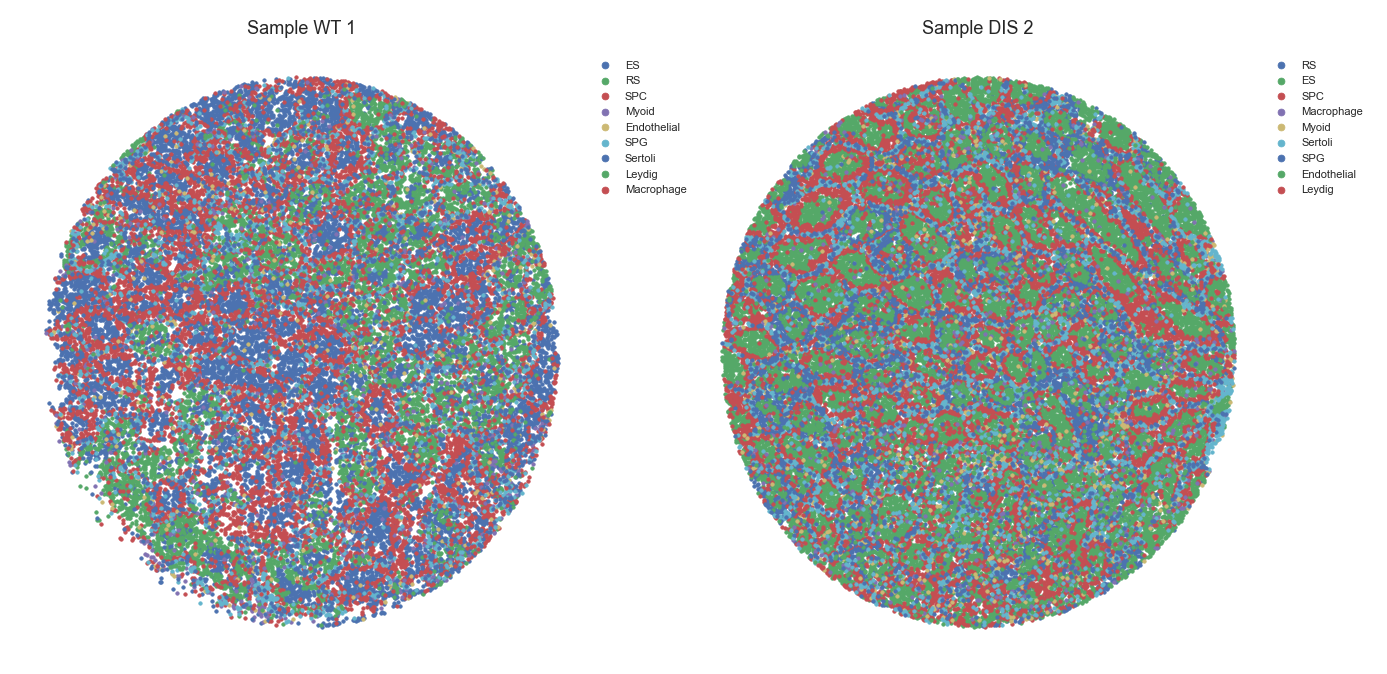

In [8]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4))
tp.plot_utils.show_raw_data(df_wt1, title="Sample WT 1", ax=ax1, point_size=1.5)
tp.plot_utils.show_raw_data(df_dis2, title="Sample DIS 2", ax=ax2, point_size=1.5)

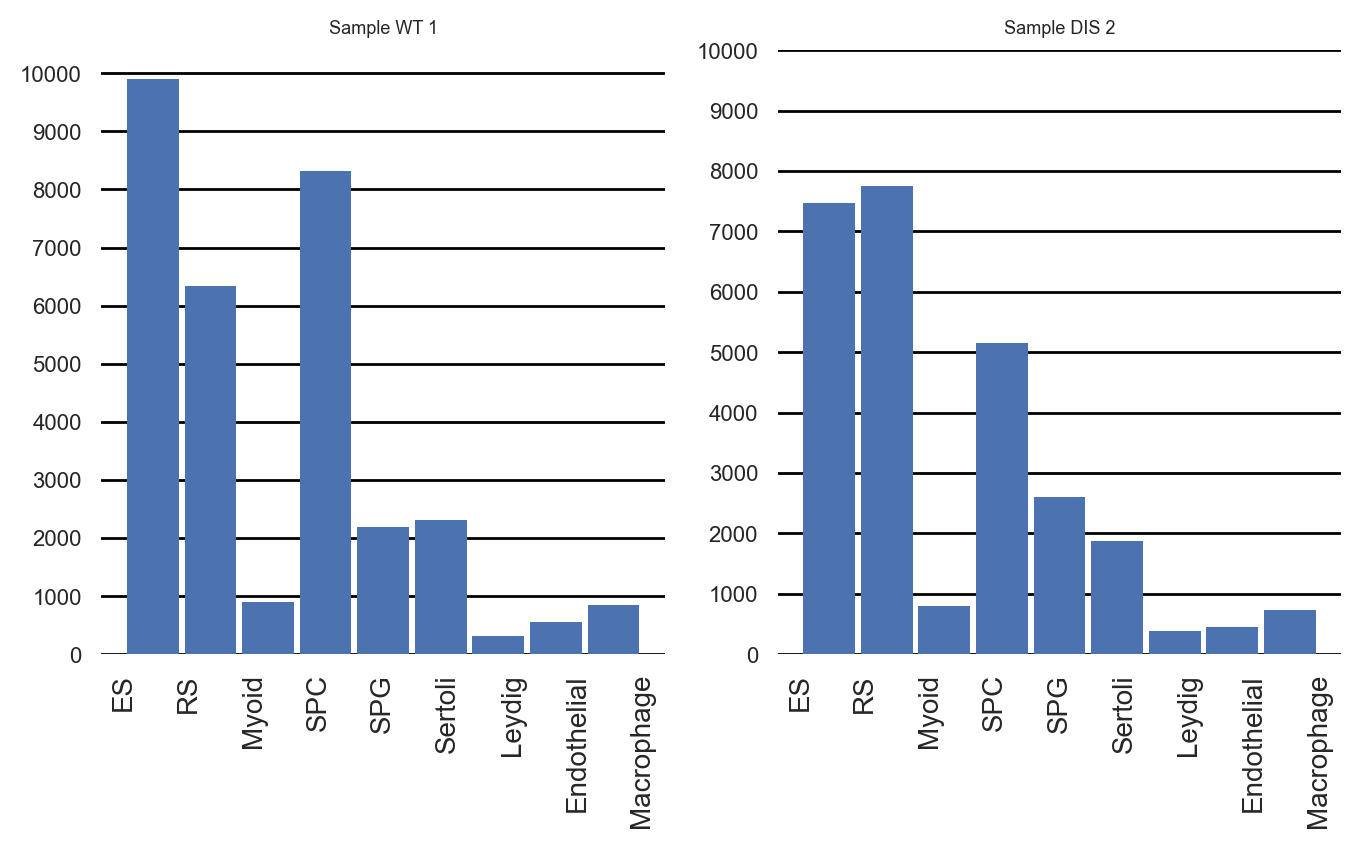

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4))
tp.plot_utils.show_cell_count(df_wt1, title="Sample WT 1", ax=ax1)
tp.plot_utils.show_cell_count(df_dis1, title="Sample DIS 2", ax=ax2)

## Create the train and test dataset using all the tissue

In [11]:
all_df = [df_wt1, df_wt2, df_wt3, df_dis1, df_dis2, df_dis3]
labels_sparse_images = [0, 0, 0, 1, 1, 1]
names_sparse_images = ["wt1", "wt2", "wt3", "dis1", "dis2", "dis3"]

sparse_images = [
    tp.data_utils.SparseImage.from_panda(
        df,
        "x",
        "y",
        category="cell_type",
        pixel_size=config["simulation"]["PIXEL_SIZE"],
        padding=10,
    )
    for df in all_df
]

number of elements ---> 31659
The dense shape of the image is -> torch.Size([9, 1168, 1168])
number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 1170, 845])
number of elements ---> 39206
The dense shape of the image is -> torch.Size([9, 1169, 1170])
number of elements ---> 27194
The dense shape of the image is -> torch.Size([9, 1166, 1170])
number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 1170, 1170])
number of elements ---> 33441
The dense shape of the image is -> torch.Size([9, 1154, 1155])


## Create and visualiza the testdata

In [12]:
from tissue_purifier.data_utils.helpers import define_testloader

testloader = define_testloader(
    sparse_images, labels_sparse_images, names_sparse_images, config
)

imgs, labels, fnames, list_sparse = next(iter(testloader))

In [21]:
print(imgs.shape)
print(labels)
print(fnames)
print(list_sparse[0])

torch.Size([128, 9, 224, 224])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
['wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt1', 'wt

## Visualize Full Image

In [126]:
image = tp.data_utils.SparseImage.from_panda(df_dis2, "x", "y", "cell_type", pixel_size=4)
image = tp.data_utils.transforms.RandomGaussianBlur((1, 1))(image.to_dense())

number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 1170, 1170])


In [127]:
image.shape

torch.Size([9, 1170, 1170])

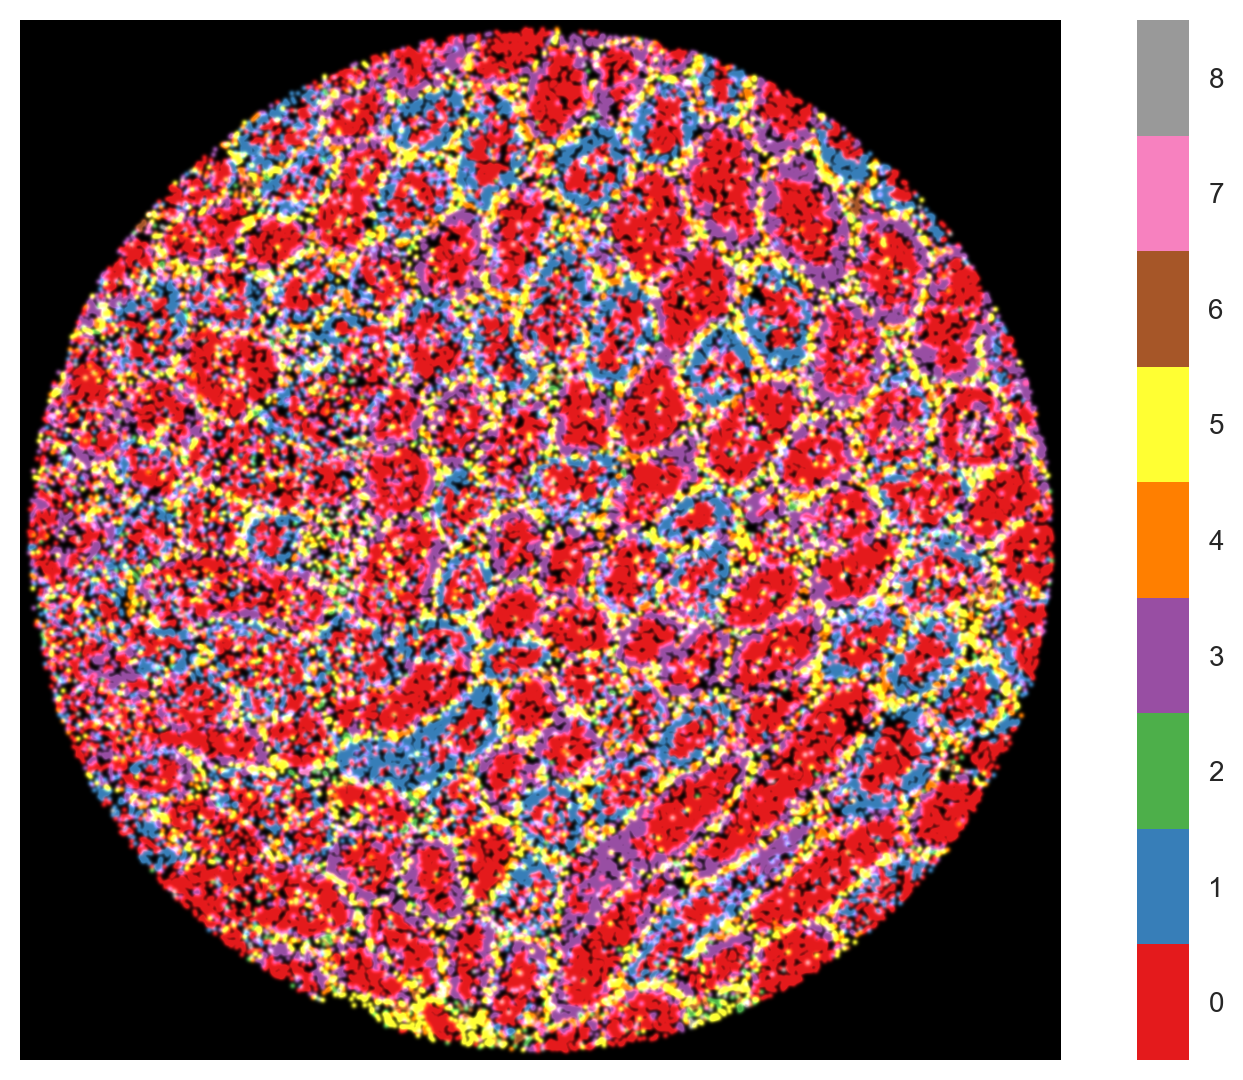

In [200]:
tp.plot_utils.show_raw_all_channels(image, cmap="Set1", intensity_scale_factor=3)

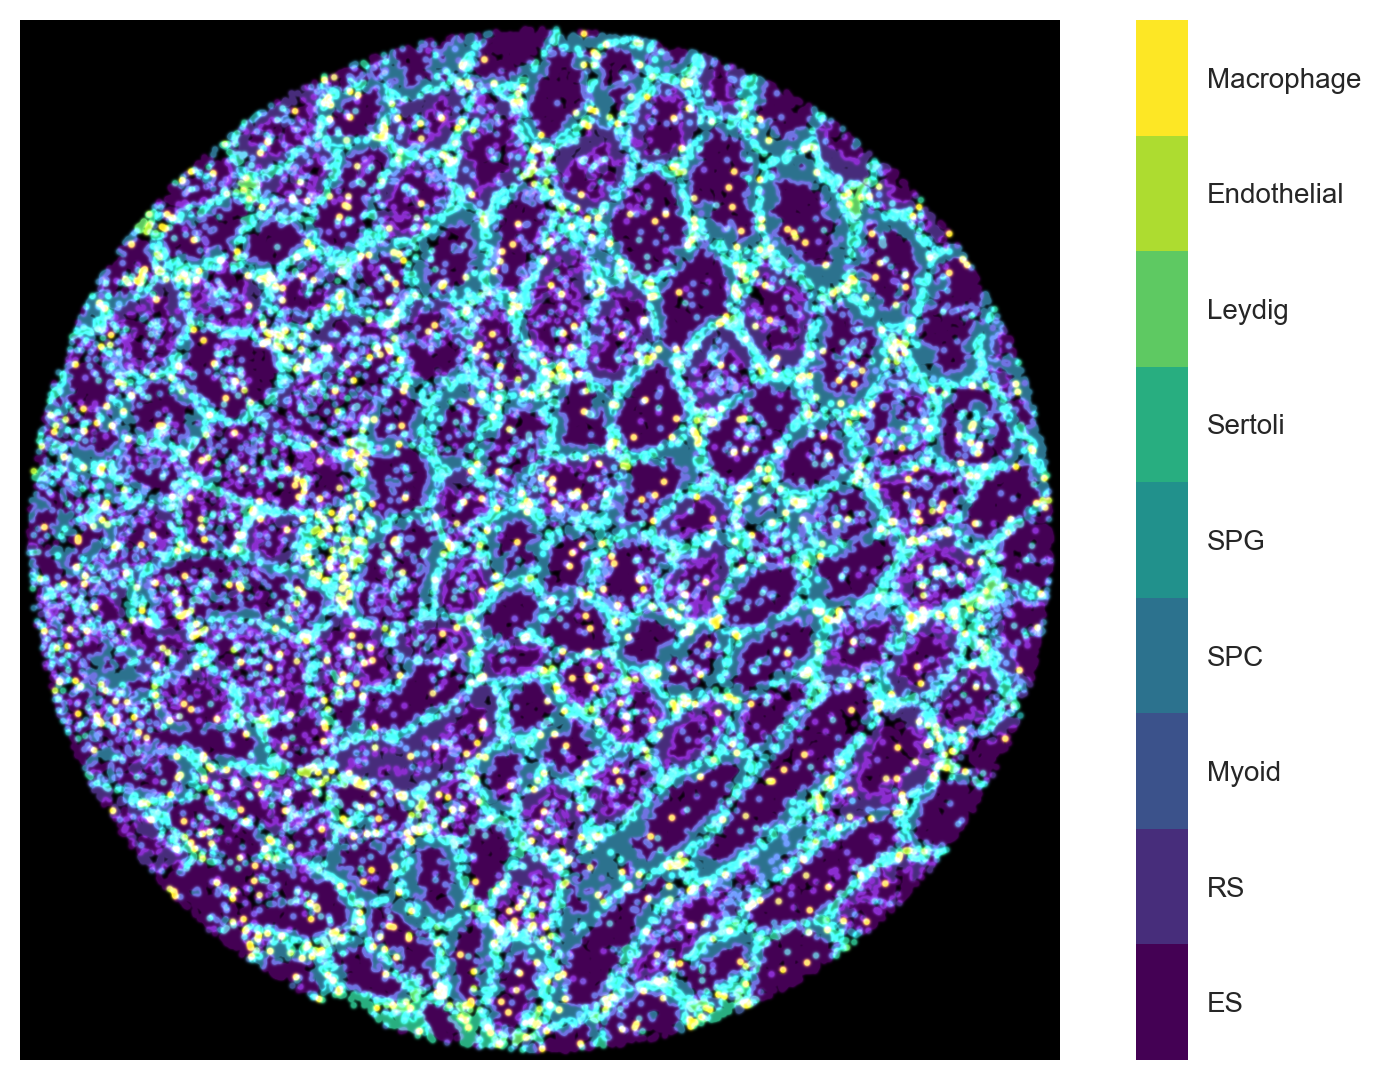

In [203]:
labels = ['ES', 'RS', 'Myoid', 'SPC', 'SPG', 'Sertoli', 'Leydig', 'Endothelial', 'Macrophage']
tp.plot_utils.show_raw_all_channels(image, cmap="viridis", intensity_scale_factor=7, labels=labels)

Plot the first channel of many different crops

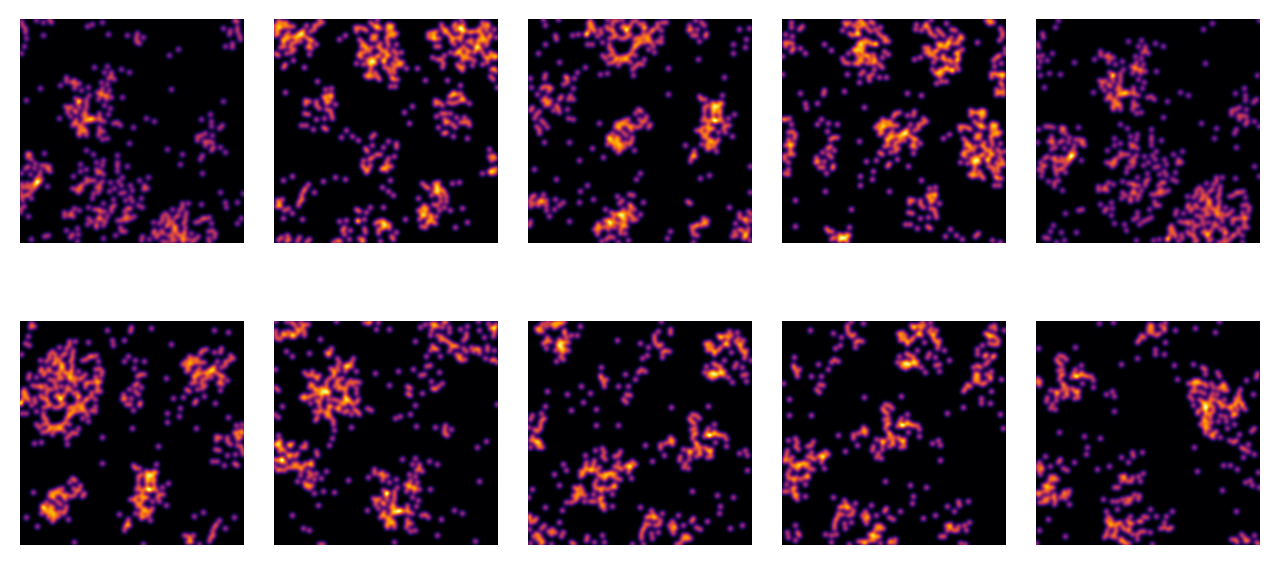

In [176]:
tp.plot_utils.show_tensor(
    imgs[:10, 0],
    figsize=(6.5, 3.5),
    n_col=5,
    cmap="inferno",
    normalize_range=(0.0, 1.0),
)

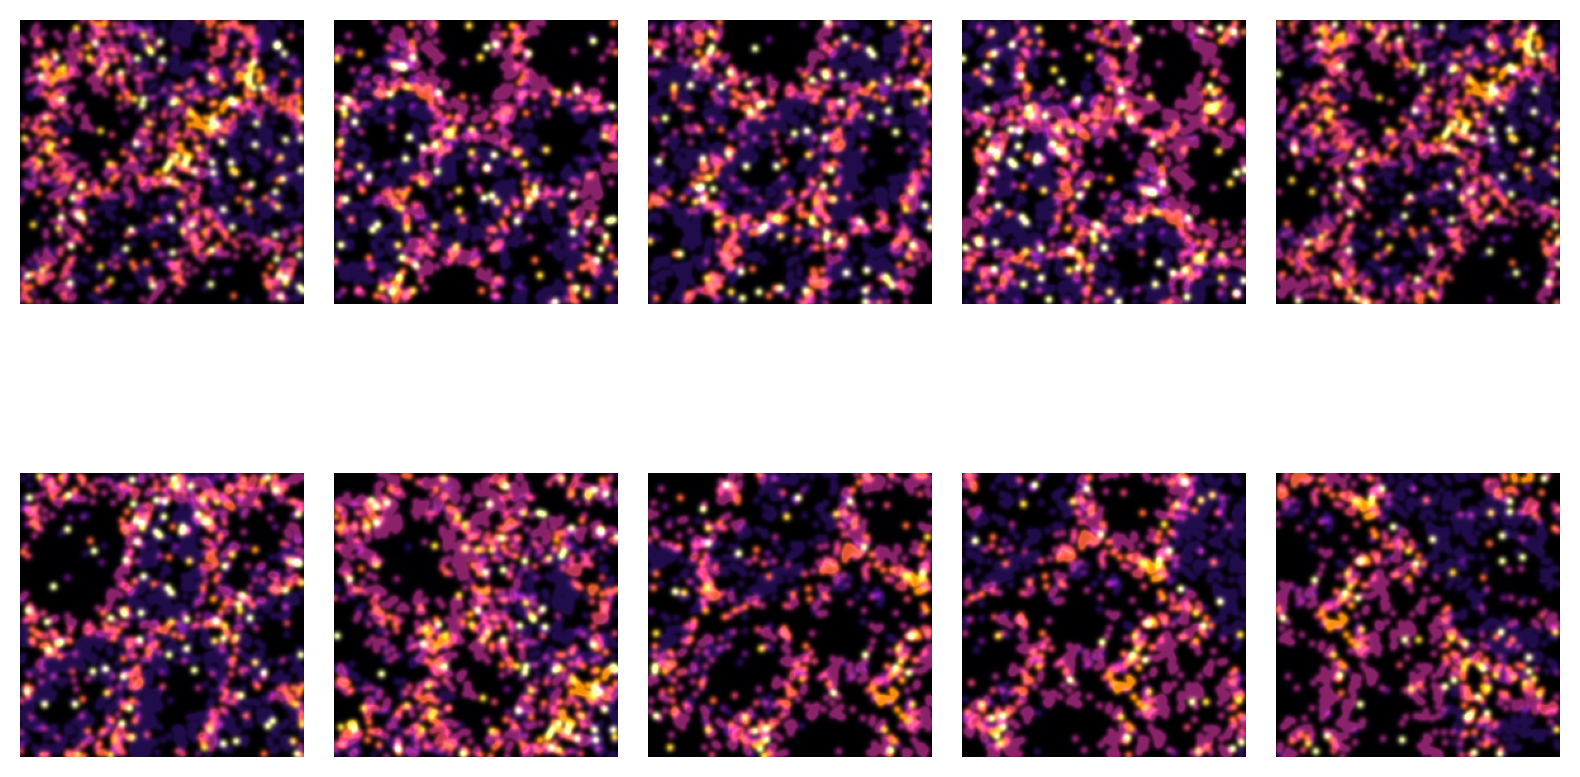

In [181]:
tp.plot_utils.show_raw_all_channels(imgs[:10], n_col=5)

Plot all the channels for the first crop

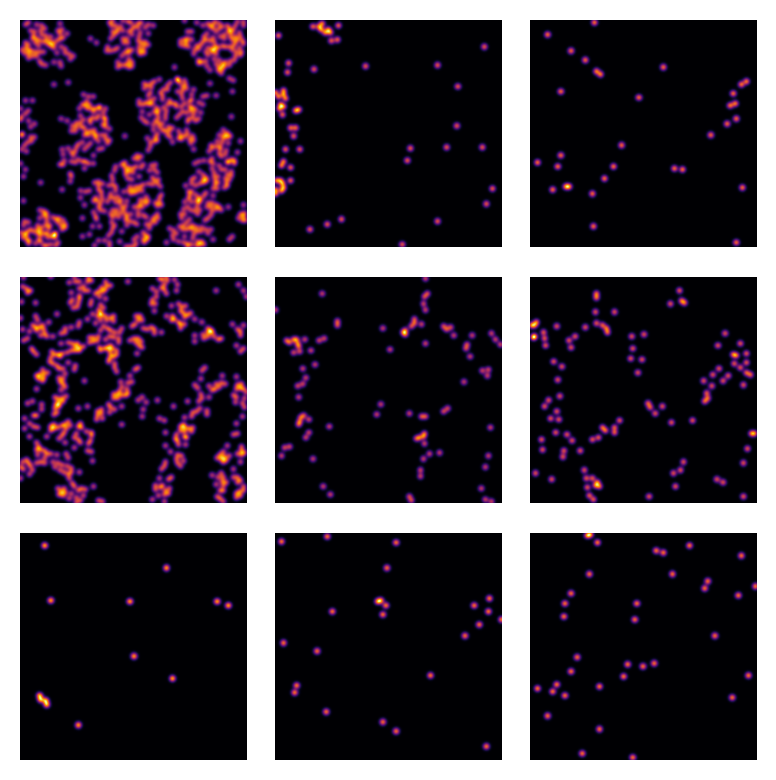

In [23]:
tp.plot_utils.show_tensor(
    imgs[0, :],
    figsize=(4,4),
    n_col=3,
    cmap="inferno",
    normalize_range=(0.0, 1.0),
)

### Create the trainloader

In [24]:
from tissue_purifier.data_utils.helpers import define_trainloader

config["simulation"]["BATCH_SIZE"] = 5  # reduce the batch size so that visualization is faster

trainloader = define_trainloader(sparse_images,
                                 labels_sparse_images,
                                 names_sparse_images,
                                 config,
                                 simclr_output=True)

(imgs0, imgs1), labels, fnames, list_sparse = next(iter(trainloader))

TypeError: define_trainloader() got an unexpected keyword argument 'simclr_output'

Visualize pairs of images which are related by data augmentation

In [ ]:
tp.plot_utils.show_tensor(
    imgs0[:5, 0], figsize=(6.3, 2), n_col=5, cmap="inferno", normalize=True
)

In [ ]:
tp.plot_utils.show_tensor(
    imgs1[:5, 0], figsize=(6.3, 2), n_col=5, cmap="inferno", normalize=True
)

In [ ]:
tp.plot_utils.show_tensor(
    imgs0[0,:], figsize=(2,2), n_col=3, cmap="inferno", normalize=True
)

In [ ]:
tp.plot_utils.show_tensor(
    imgs1[0,:], figsize=(2,2), n_col=3, cmap="inferno", normalize=True
)